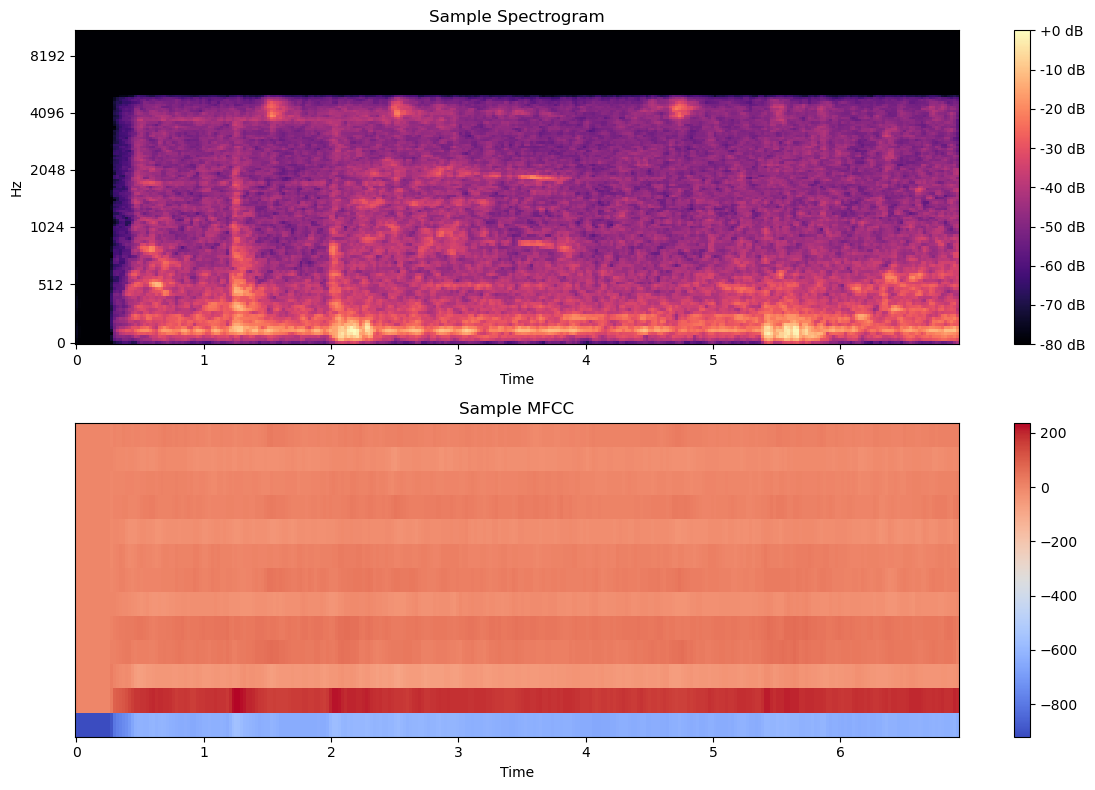

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Define the function to save processed data
def save_processed_data(data, label, save_path):
    np.savez(save_path, data=data, label=label)

path_to_the_dataset = 'donateacry_corpus_cleaned_and_updated_data'

# List of subfolders
subfolders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

# Function to save the processed data

for subfolder in subfolders:
    folder_path = os.path.join(path_to_the_dataset, subfolder)

    for audio_file in os.listdir(folder_path):
        if audio_file.endswith(".wav"):
            audio_path = os.path.join(folder_path, audio_file)

            # Load the audio file using Librosa
            audio, sr = librosa.load(audio_path)

            # Compute the spectrogram
            spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
            spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

            # Save the spectrogram data
            save_path_spectrogram = os.path.join(folder_path, f"{os.path.splitext(audio_file)[0]}_spectrogram.npz")
            save_processed_data(spectrogram_db, subfolder, save_path_spectrogram)

            # Compute the MFCCs
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

            # Save the MFCC data
            save_path_mfcc = os.path.join(folder_path, f"{os.path.splitext(audio_file)[0]}_mfcc.npz")
            save_processed_data(mfccs, subfolder, save_path_mfcc)

# Display a sample spectrogram and MFCC
plt.figure(figsize=(12, 8))

# Display a sample spectrogram
plt.subplot(2, 1, 1)
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Sample Spectrogram')

# Display a sample MFCC
plt.subplot(2, 1, 2)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title('Sample MFCC')

plt.tight_layout()
plt.show()


In [27]:
# Import necessary libraries
import os
from sklearn.model_selection import train_test_split

# Define the base path of your dataset
path_to_your_dataset = 'donateacry_corpus_cleaned_and_updated_data'

# List the subfolders corresponding to each class
subfolders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

# Initialize lists to store file paths and labels
data = []    # This list will store the paths of audio files
labels = []  # This list will store the corresponding labels (class indices)

# Iterate through each subfolder
for label, subfolder in enumerate(subfolders):
    folder_path = os.path.join(path_to_your_dataset, subfolder)
    
    # Iterate through each audio file in the subfolder
    for audio_file in os.listdir(folder_path):
        if audio_file.endswith(".wav"):
            audio_path = os.path.join(folder_path, audio_file)
            data.append(audio_path)
            labels.append(label)

# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Display the size of the training and testing sets
print(f"Size of the training set: {len(train_data)}")
print(f"Size of the testing set: {len(test_data)}")

Size of the training set: 365
Size of the testing set: 92


In [32]:
import os
import librosa
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# Function to extract audio features (spectrograms)
def extract_features(audio_path):
    audio, _ = librosa.load(audio_path, res_type='kaiser_fast')
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=22050, n_mels=128, fmax=8000)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

# Function to reshape and truncate the spectrograms
def reshape_and_truncate(spectrogram, target_shape):
    if spectrogram.shape[1] > target_shape:
        return spectrogram[:, :target_shape]
    else:
        return np.pad(spectrogram, ((0, 0), (0, target_shape - spectrogram.shape[1])))

# Function to process audio file and make a prediction
def predict_audio_class(audio_path, model, label_encoder, min_shape):
    # Extract features of the new audio
    new_audio_features = extract_features(audio_path)

    # Ensure features have the same shape as those used for training
    new_audio_features = reshape_and_truncate(new_audio_features, min_shape)

    # Flatten features for use in the model
    new_audio_features_flatten = new_audio_features.reshape((1, -1))

    # Predict the class of the new audio
    predicted_class = model.predict(new_audio_features_flatten)

    # Convert the prediction to a label
    predicted_label = label_encoder.inverse_transform(predicted_class)

    return predicted_label[0]

# Define the base path of your dataset
path_to_your_dataset = 'donateacry_corpus_cleaned_and_updated_data'

# List the subfolders corresponding to each class
subfolders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

# Initialize lists to store file paths and labels
data = []    # This list will store the paths of audio files
labels = []  # This list will store the corresponding labels (class names)

# Iterate through each subfolder
for label, subfolder in enumerate(subfolders):
    folder_path = os.path.join(path_to_your_dataset, subfolder)
    
    # Iterate through each audio file in the subfolder
    for audio_file in os.listdir(folder_path):
        if audio_file.endswith(".wav"):
            audio_path = os.path.join(folder_path, audio_file)
            data.append(audio_path)
            labels.append(subfolder)

# Convert labels to numbers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data, train_labels, test_labels = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)

# Create training and testing sets
X_train = [extract_features(audio_path) for audio_path in train_data]
X_test = [extract_features(audio_path) for audio_path in test_data]

# Find the minimum shape of the spectrograms
min_shape = min([spectrogram.shape[1] for spectrogram in X_train + X_test])

# Function to apply reshape_and_truncate to all spectrograms
def process_spectrograms(spectrograms, target_shape):
    return [reshape_and_truncate(spectrogram, target_shape) for spectrogram in spectrograms]

# Apply reshape_and_truncate to all spectrograms
X_train = process_spectrograms(X_train, min_shape)
X_test = process_spectrograms(X_test, min_shape)

# Convert lists to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# Flatten the input data
X_train_flatten = X_train.reshape((X_train.shape[0], -1))
X_test_flatten = X_test.reshape((X_test.shape[0], -1))

# Create the SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Train the model
svm_model.fit(X_train_flatten, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_flatten)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy}")

# Replace 'path/to/your/audio.wav' with the path of the audio you want to test
audio_path_to_test = 'baby-crying-01.wav'

# Make a prediction for the new audio
predicted_class = predict_audio_class(audio_path_to_test, svm_model, label_encoder, min_shape)

# Display the prediction
print(f"Predicted class for the new audio: {predicted_class}")


Accuracy on the test set: 0.75
Predicted class for the new audio: hungry


In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Define the base path of your dataset
path_to_your_dataset = 'donateacry_corpus_cleaned_and_updated_data'

# List the subfolders corresponding to each class
subfolders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

# Initialize lists to store file paths and labels
data = []    # This list will store the paths of audio files
labels = []  # This list will store the corresponding labels (class names)

# Iterate through each subfolder
for label, subfolder in enumerate(subfolders):
    folder_path = os.path.join(path_to_your_dataset, subfolder)
    
    # Iterate through each audio file in the subfolder
    for audio_file in os.listdir(folder_path):
        if audio_file.endswith(".wav"):
            audio_path = os.path.join(folder_path, audio_file)
            data.append(audio_path)
            labels.append(subfolder)

# Convert labels to numbers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data, train_labels, test_labels = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)

# Function to extract audio features (spectrograms)
def extract_features(audio_path):
    audio, _ = librosa.load(audio_path, res_type='kaiser_fast')
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=22050, n_mels=128, fmax=8000)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

# Create training and testing sets
X_train = [extract_features(audio_path) for audio_path in train_data]
X_test = [extract_features(audio_path) for audio_path in test_data]

# Convert lists to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# Add a dimension to indicate the channel (1 for grayscale)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

# Convert labels to one-hot format
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Create the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(subfolders), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test, y_test_one_hot))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print(f"Accuracy on the test set: {test_acc}")
